<a href="https://colab.research.google.com/github/rpezoa/Intro_XAI/blob/main/09_Linear_Regression_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes neuronales con funciones de pérdida apropiadas para ajustar modelos de regresión flexibles

**Objetivo:**  
En este notebook se adapta paso a paso la arquitectura de la red neuronal y la función de pérdida para desarrollar un modelo de regresión que logre un buen ajuste. Se usa un conjunto de datos simulado con dos variables (`x`, `y`) que muestran una dependencia no lineal de `y` con respecto a `x`, y una variabilidad de los datos que no es constante. Se visualiza que es necesario agregar capas ocultas no lineales si deseas modelar relaciones no lineales. Además, se necesita una red neuronal con dos nodos de salida cuando se quiere modelar una distribución condicional normal (CPD) con parámetros $\mu$ y $\sigma$, especialmente si $\sigma$ no es constante (heterocedasticidad).

**Uso:**  
La idea del notebook es entender el código proporcionado ejecutándolo y revisando su salida y jugando con él, haciendo pequeños cambios y volviéndolo a ejecutar.

**Conjunto de datos:**  
Un conjunto de datos simulado con una onda senoidal que tiene una pequeña tendencia lineal positiva y una varianza que depende de la amplitud.

**Contenido:**

- Simular un conjunto de datos con una relación no lineal entre `x` e `y` y una variabilidad cambiante de los datos.

- Ver la regresión como un modelo para la CPD normal donde la media y la desviación estándar dependen de `x`.

- **Primer modelo:**  
  Usar una red neuronal sin capas ocultas y con un nodo de salida para ajustar una regresión lineal donde solo el parámetro de la media de la CPD depende de `x`. La función de pérdida está dada por la NLL, la cual se reduce al MSE si se asume una varianza constante.

- **Segundo modelo:**  
  Usar una red neuronal con capas ocultas y un nodo de salida para ajustar una regresión donde el parámetro de la media de la CPD puede depender no linealmente de `x`. La función de pérdida sigue siendo la NLL, que se reduce al MSE si se asume varianza constante.

- **Tercer modelo:**  
  Usar una red neuronal con capas ocultas y dos nodos de salida para ajustar una regresión donde tanto la media como la desviación estándar de la CPD pueden depender no linealmente de `x`. La función de pérdida está dada por la NLL, que **ya no se reduce al MSE**, ya que no se asume una varianza constante.

#### Install correct TF version (colab only)

In [14]:
#versiones necesarios para poder ejecutar
try:
  import google.colab
  !pip install tensorflow==2.15.0
  ! pip install numpy==1.26.4
except:
  print('Not running in colab')

In [15]:
import tensorflow as tf
import numpy as np
print(tf.__version__)
print(np.__version__)

2.15.0
1.26.4


#### Imports
In the next three cells, we load all the required libraries and simulate and plot a dataset with a sine wave that has small linear slope and variace that gets bigger with the amplitude.


In [16]:
try: #If running in colab
    import google.colab
    IN_COLAB = True
    %tensorflow_version 2.x
except:
    IN_COLAB = False

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [17]:
import tensorflow as tf
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.15.0  running in colab?:  True


In [18]:
#load required libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation
from tensorflow.keras import optimizers

tf.__version__

'2.15.0'

#### Datos simulados

In [20]:
def create_sine_data(n = 300):
    np.random.seed(32)
    n = 300
    x = np.linspace(0,1*2*np.pi,n)
    y1 = 3*np.sin(x)
    y1 = np.concatenate((np.zeros(60), y1+np.random.normal(0,0.15*np.abs(y1),n),np.zeros(60)))
    x=np.concatenate((np.linspace(-3,0,60),np.linspace(0,3*2*np.pi,n),np.linspace(3*2*np.pi,3*2*np.pi+3,60)))
    y2 = 0.1*x+1
    y=y1+y2
    return x,y

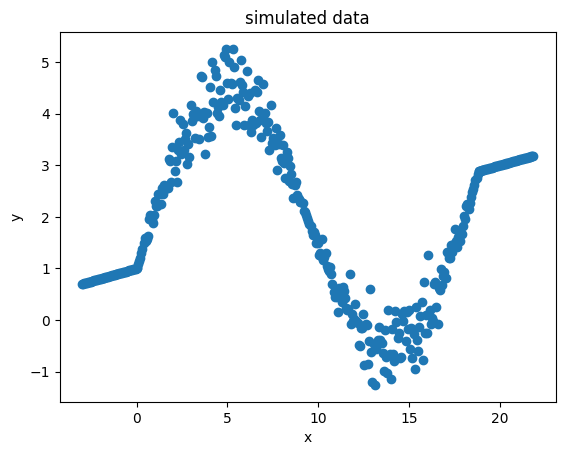

In [21]:
x,y = create_sine_data(n=300) #A
plt.scatter(x=x,y=y,marker='o')
plt.title("simulated data")
plt.xlabel("x")
plt.ylabel("y")
n=len(x)

## Primer modelo: NN para la regresión lineal simple

- Se usará una red neuronal sin capa oculta y con un nodo de salida para ajustar un modelo de regresión lineal, en el cual el parámetro de la media de la CPD depende linealmente de `x`.

- Dado que la varianza no será modelada, la función de pérdida o NLL estará dada por el error cuadrático medio (MSE) (ver deducción en la sección 4.3).


In [22]:
# Configuración de una red neuronal sin capa oculta y con un solo nodo de salida.
# Se supone que la media de la CPD depende linealmente de `x` y
# que la desviación estándar de la CPD es constante y no es modelada.

model = Sequential()
model.add(Dense(1, activation='linear',batch_input_shape=(None, 1)))
model.compile(loss='mean_squared_error',optimizer="adam")

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Entrenamiento del primer modelo y ajuste en los datos

In [25]:
history=model.fit(x, y,
                  batch_size=16,
                  epochs=1000,
                  verbose=0,
                 )

In [26]:
model.evaluate(x,y,verbose=2)

14/14 - 0s - loss: 2.4825 - 76ms/epoch - 5ms/step


2.4825003147125244

14/14 [==============================] - 0s 2ms/step


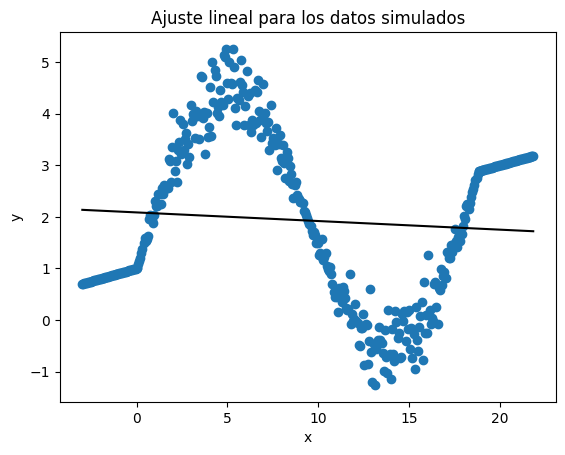

In [28]:
plt.scatter(x=x,y=y,marker='o')
plt.plot(x,model.predict(x),c="black")
plt.title("Ajuste lineal para los datos simulados")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


Como se puede observar, el modelo lineal **no logra ajustar adecuadamente** los datos. Esto no es sorprendente, ya que no se utilizaron capas ocultas, y sin ellas no es posible modelar dependencias no lineales.


In [29]:
# obtener pendiente e itercepto
model.get_weights()

[array([[-0.01670272]], dtype=float32), array([2.085508], dtype=float32)]

## Segundo modelo: Red neuronal para un modelo de regresión no lineal

Ahora se usará una red neuronal con tres capas ocultas y un nodo de salida para ajustar un modelo de regresión lineal, donde el parámetro de la media de la CPD puede depender no linealmente de `x`. Dado que la varianza no es modelada, la función de pérdida o NLL está dada por el error cuadrático medio (MSE) (ver deducción en la sección 4.3).


##### Red neuronal totalmente conectada con 3 capas ocultas para modelar relaciones no lineales utilizando la función de pérdida MSE


In [30]:
# Configuración de una red neuronal con 3 capas ocultas y un solo nodo de salida
# Esto permite que la media de la CPD dependa no linealmente de x
# y que la desviación estándar de la CPD sea constante y no sea modelada

model = Sequential()
model.add(Dense(20, activation='relu',
                batch_input_shape=(None, 1)))
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error',optimizer="adam")

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 20)                40        
                                                                 
 dense_3 (Dense)             (None, 50)                1050      
                                                                 
 dense_4 (Dense)             (None, 20)                1020      
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2131 (8.32 KB)
Trainable params: 2131 (8.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Entrenamiento del segundo modelo y ajuste en los datos

In [32]:
# train the model
history=model.fit(x, y,
                  batch_size=16,
                  epochs=1000,
                  verbose=0,
                 )

In [33]:
# Evaluación de la función de pérdida MSE
model.evaluate(x,y,verbose=2)

14/14 - 0s - loss: 0.0711 - 357ms/epoch - 26ms/step


0.07112768292427063

32/32 [==============================] - 0s 2ms/step


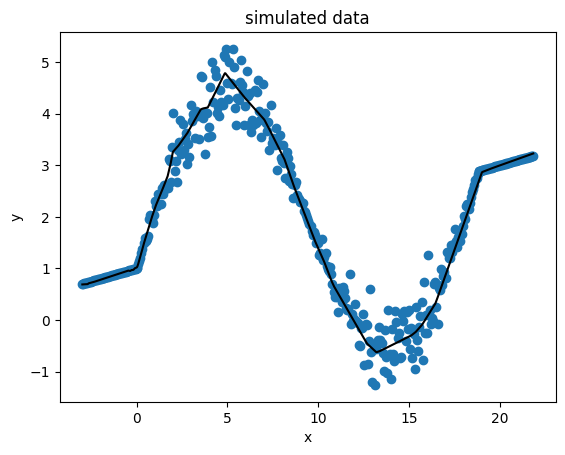

In [34]:
plt.scatter(x=x,y=y,marker='o')
plt.plot(np.linspace(-3,3*2*np.pi+3,1000),model.predict(np.linspace(-3,3*2*np.pi+3,1000)),c="black")
plt.title("simulated data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Como se puede observar ahora, la red neuronal con capas ocultas logra ajustar adecuadamente los datos. A continuación, se intentará capturar también la varianza de los datos.


## Tercer modelo: Red neuronal para un modelo de regresión no lineal con varianza cambiante

Ahora se utilizará una red neuronal nuevamente con tres capas ocultas, pero esta vez con dos nodos de salida, para ajustar un modelo de regresión lineal donde los parámetros de la media $\mu$ y la desviación estándar $\sigma$ de la CPD pueden depender no linealmente de `x`. Dado que ahora también se modela la varianza, la función de pérdida, que corresponde a la NLL, ya no está dada por el MSE, sino que tiene una forma más compleja (ver deducción en la sección 4.3). Keras no proporciona esta función de pérdida, por lo que será necesario definirla manualmente.


#### Red neuronal totalmente conectada con capas ocultas, dos nodos de salida y una función de pérdida personalizada para ajustar un modelo de regresión no lineal heterocedástico
                                                                                                                                  


In [49]:
# definir la función de pérdida que corresponde a la NNL
import math
def my_NLL_loss(y_true,y_pred):
  mu=tf.slice(y_pred,[0,0],[-1,1])              # A
  sigma=tf.math.exp(tf.slice(y_pred,[0,1],[-1,1]))   # B

  a=1/(tf.sqrt(2.*math.pi)*sigma)
  b1=tf.square(mu-y_true)
  b2=2*tf.square(sigma)
  b=b1/b2

  loss = tf.reduce_sum(-tf.math.log(a)+b,axis=0)
  return loss

# A extraer la primera columna para μ
# B extraer la segunda columna para σ

In [50]:
# Configuración del modelo con 3 capas ocultas y 2 nodos de salida
# Esto permite que la media de la CPD dependa no linealmente de x
# y que también la desviación estándar pueda depender no linealmente de x

model =  Sequential()
model.add(Dense(20, activation='relu',batch_input_shape=(None, 1)))
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(2, activation='linear'))

model.compile(loss=my_NLL_loss,optimizer="adam",metrics=[my_NLL_loss])


In [51]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 20)                40        
                                                                 
 dense_15 (Dense)            (None, 50)                1050      
                                                                 
 dense_16 (Dense)            (None, 20)                1020      
                                                                 
 dense_17 (Dense)            (None, 2)                 42        
                                                                 
Total params: 2152 (8.41 KB)
Trainable params: 2152 (8.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Entrenamiento del tercer modelo y ajuste de los datos

In [52]:
history=model.fit(x, y,
                  batch_size=16,
                  epochs=1000,
                  verbose=0
                 )

In [53]:
x_pred=np.linspace(-3,3*2*np.pi+3,1000).reshape(1000,1)
pred_mu=model.predict(np.linspace(-3,3*2*np.pi+3,1000).reshape(1000,1))[:,0]

32/32 [==============================] - 0s 1ms/step


In [54]:
pred_log_sigma=model.predict(np.linspace(-3,3*2*np.pi+3,1000).reshape(1000,1))[:,1]

32/32 [==============================] - 0s 1ms/step


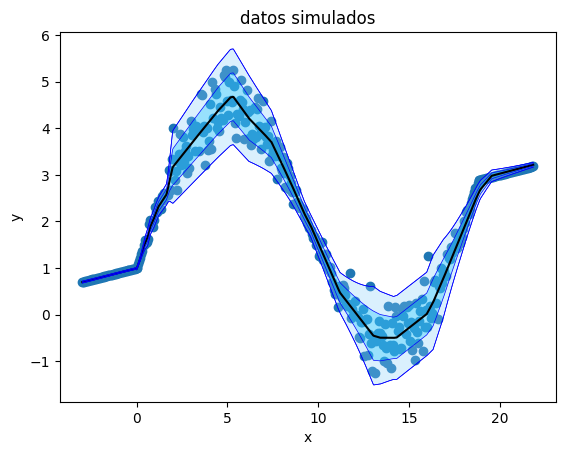

In [56]:
# Mostrar los datos junto con el ajuste más/menos 2 veces la desviación estándar

plt.scatter(x,y,marker='o')
plt.plot(x_pred,pred_mu,c="black")

pred_1_sd_p = pred_mu+(np.exp(pred_log_sigma))
pred_1_sd_m = pred_mu-(np.exp(pred_log_sigma))

plt.plot(x_pred,pred_1_sd_p, 'b', linewidth=0.5)
plt.plot(x_pred,pred_1_sd_m, 'b', linewidth=0.5)

pred_2_sd_p = pred_mu+2*(np.exp(pred_log_sigma))
pred_2_sd_m = pred_mu-2*(np.exp(pred_log_sigma))

plt.plot(x_pred,pred_2_sd_p, 'b', linewidth=0.5)
plt.plot(x_pred,pred_2_sd_m, 'b', linewidth=0.5)

plt.plot(x_pred,pred_mu+2*(np.exp(pred_log_sigma)), 'b', linewidth=0.5)
plt.plot(x_pred,pred_mu-2*(np.exp(pred_log_sigma)), 'b', linewidth=0.5)

plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
         np.concatenate([pred_2_sd_p,
                         pred_2_sd_m[::-1]]),alpha=0.3, fc='lightskyblue', ec='None')
plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
         np.concatenate([pred_1_sd_p,
                         pred_1_sd_m[::-1]]),alpha=0.3, fc='deepskyblue', ec='None')
plt.title("datos simulados")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Suavidad del ajuste en función de la función de activación

<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  

**Ejercicio 1:** Cambia las funciones de activación en la última red neuronal de `relu` a `sigmoid` y repite el análisis. ¿Qué observas?


Scroll down to see the solution.

</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>

In [ ]:
# set up the model with3  hidden layers and 2 output nodes
# This allows that the mean of the CPD depends non-linearly on x
# and also the standard deviation can depend non-linearly on x
model =  Sequential()
model.add(Dense(20, activation='sigmoid',batch_input_shape=(None, 1)))
model.add(Dense(50, activation='sigmoid'))
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(2, activation='linear'))

model.compile(loss=my_NLL_loss,optimizer="adam",metrics=[my_NLL_loss])

In [ ]:
# summarize model along with number of model weights
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 20)                40        
_________________________________________________________________
dense_14 (Dense)             (None, 50)                1050      
_________________________________________________________________
dense_15 (Dense)             (None, 20)                1020      
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 42        
Total params: 2,152
Trainable params: 2,152
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train the model
history=model.fit(x, y,
                  batch_size=16,
                  epochs=1500,
                  verbose=0
                 )

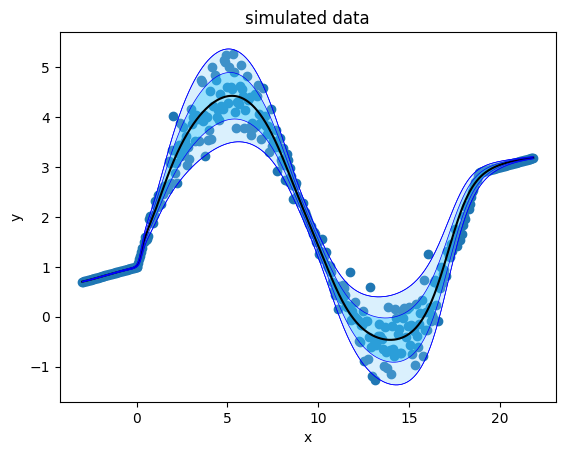

In [ ]:
# show the data along with the fit plus/minus 2-times the standard deviation
x_pred=np.linspace(-3,3*2*np.pi+3,1000).reshape(1000,1)
pred_mu=model.predict(np.linspace(-3,3*2*np.pi+3,1000).reshape(1000,1))[:,0]
pred_log_sigma=model.predict(np.linspace(-3,3*2*np.pi+3,1000).reshape(1000,1))[:,1]
plt.scatter(x,y,marker='o')
plt.plot(x_pred,pred_mu,c="black")

pred_1_sd_p = pred_mu+(np.exp(pred_log_sigma))
pred_1_sd_m = pred_mu-(np.exp(pred_log_sigma))

plt.plot(x_pred,pred_1_sd_p, 'b', linewidth=0.5)
plt.plot(x_pred,pred_1_sd_m, 'b', linewidth=0.5)

pred_2_sd_p = pred_mu+2*(np.exp(pred_log_sigma))
pred_2_sd_m = pred_mu-2*(np.exp(pred_log_sigma))

plt.plot(x_pred,pred_2_sd_p, 'b', linewidth=0.5)
plt.plot(x_pred,pred_2_sd_m, 'b', linewidth=0.5)

plt.plot(x_pred,pred_mu+2*(np.exp(pred_log_sigma)), 'b', linewidth=0.5)
plt.plot(x_pred,pred_mu-2*(np.exp(pred_log_sigma)), 'b', linewidth=0.5)

plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
         np.concatenate([pred_2_sd_p,
                         pred_2_sd_m[::-1]]),alpha=0.3, fc='lightskyblue', ec='None')
plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
         np.concatenate([pred_1_sd_p,
                         pred_1_sd_m[::-1]]),alpha=0.3, fc='deepskyblue', ec='None')
plt.title("simulated data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


#### Solution
When using sigmoid as activation function you get a different result: The curves for the fit (mean) and also the curves for the reference interval (mean plus/minus 2-times stddev) now apprear much smoother. This effect is probably due to the fact that relus are not smooth and if you change the input to a ReLU from negative to small positive, it gets activated and contributes to the output. We also observe that we need to train for more epochs with sigmoids than with relus, this is due the smaller gradients and updatesteps that backpropagate with the sigmoid activation.